<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Nutri-Grade labels

---
## Problem Statement
Singaporeans are living longer but spending more time in ill-health. There are top 3 chronic medical conditions that Singaporeans suffer from are: Hypertension, Diabetes and Hyperlipidemia<br>

There are 3 main ways to prevent chronic illness:
- Physical Activity (Engage in at least 150-300 minutes of moderate-intensity aerobic activity in a week)
- Diet (Consume the receommended dietary allowances for sugar, saturated fat and salt)
- Healthy life choices (Avoid tobacco and excessive drinking)<br>

We will focus on the diet portion. More than half of Singaporeans’ daily sugar intake comes from beverages. This is why the government has came up with a nutri-grade labelling system in hopes that Singaporeans will reduce their sugar intake by making heatheir choices when choosing which drink to buy. However the nutrigrade labels only take into account trans fat and sugar and do not provide a holistic picture of the health of the drinks. Is there a way to create a more comprehensive indicator of how healthy drinks are?

## Contents:
- [Import libraries](#Import-libraries)
- [Import data](#Import-data)
- [1. Identifying non-numeric columns](#1.-Identifying-non-numeric-columns)
- [2. One Hot Encode](#2.-One-Hot-Encode)
- [3. SMOTE](#3.-SMOTE)
- [4. Standard Scaler](#4.-Standard-Scaler)
- [5. Principal Component Analysis](#5.-Principal-Component-Analysis)
- [6. Elbow Method](#6.-Elbow-Method)
- [7. K-means clustering](#7.-K-means-clustering)
- [8. Gaussian Mixture Model Clustering & Spectral Clustering](#8.-Gaussian-Mixture-Model-Clustering-&-Spectral-Clustering)
- [9.(A&B). RandomForest](#9.(A&B).-RandomForest)
- [10.(A&B) XGBoost](#10.(A&B)-XGBoost)
- [11. Pickle file for deployment](#11.-Pickle-file-for-deployment)
- [12. Conclusion](#12.-Conclusion)

# Import libraries

In [1]:
# Importing the libraries necessary to train the models
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from imblearn.over_sampling import SMOTE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Import data

In [2]:
model = pd.read_csv('../data/model_csv.csv')

# 1. Identifying non-numeric columns.

###### In the following cell, we're identifying non-numeric columns because k-means clustering is a distance based algorithm. It calculates the distance between data points to determine clusters. These distances are computed using numerical values. Therefore, if our datasets contains non-numeric columns, the algorithm will not be able to process them.

In [3]:
#This code identifies and lists the names of numeric and non-numeric columns from the model DataFrame
numeric_columns = model.select_dtypes(include=['float64', 'int64']).columns.tolist()
non_numeric_columns = model.select_dtypes(exclude=['float64', 'int64']).columns.tolist()

# 2. One Hot Encode

###### 1. Numerical Conversion: OHE transforms categorical data for machine learning algorithms.
###### 2. Avoids Misinterpretation: Prevents models from assuming ordinal relationships in categories.
###### 3. Preserves Information: Ensures each category is independently represented in the model.

In [4]:
# One-Hot Encoding (OHE) the non-numeric columns
encoder = OneHotEncoder(drop='first', sparse=False)
model_encoded = pd.DataFrame(encoder.fit_transform(model[non_numeric_columns]), 
                             columns=encoder.get_feature_names_out(non_numeric_columns))

In [5]:
# Combine the numeric and encoded columns
model_combined = pd.concat([model[numeric_columns], model_encoded.reset_index(drop=True)], axis=1)

# 3. SMOTE : Synthetic Minority Oversampling Technique

###### During the cleaning and classifying the drinks based on ABCD according to HPB guidelines, we have noticed a large discrepancy of rows between A,B,C,D. To ensure the model is accurate, we check the number of rows that belongs to columns A,B,C,D. Therefore, we will use SMOTE to upsample classes which are significantly lesser than the others.

###### 1. Check the number of rows thats belongs to A , B , C, D
###### 2. SMOTE the other 3 classes to match the dominant class

In [6]:
# Check the distribution of the 'nutrigrade' values
nutrigrade_distribution = model['nutrigrade'].value_counts()
nutrigrade_distribution


D    174
A    115
C     85
B     50
Name: nutrigrade, dtype: int64

#### Preperation of SMOTING.

###### 1. Dropping columns for Nutrigrade B,C,D because these columns are OHE-d representations of the nutrigrade Y variable
###### 2. This is done so to prevent multicollinearity
###### 3. To use the original Nutrigrade column as Y for prediction

In [7]:
# Separate the data into features and target
X = model_combined.drop(columns=['nutrigrade_B', 'nutrigrade_C', 'nutrigrade_D'])
y = model['nutrigrade']

X.shape, y.shape

((424, 953), (424,))

In [8]:
# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the distribution of the resampled 'nutrigrade' values
y_resampled_distribution = y_resampled.value_counts()
y_resampled_distribution

B    174
A    174
C    174
D    174
Name: nutrigrade, dtype: int64

##### The classes are now balanced after applying SMOTE

# 4. Standard Scaler

#### In the following cell, we will use standard scaler for these reasons

###### 1. Its used to standardize features by removing the mean and scaling to unit variance
###### 2. Ensures that all features contribute equally to model's performance. Improving accuracy and stability.

In [9]:
# Standardize the resampled data for better clustering results
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# 5. Principal Component Analysis(PCA)

###### 1. We're using PCA to reduce the number of features whilst preserving information
###### 2. Transforms data into 2D or 3D for easier visualizations
###### 3. Helps in removing noise by focusing on data variance

In [10]:
# Reduce data dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled_scaled)

 # 6. Elbow method
 
###### The Elbow method helps determine the optimal number of clusters for k-means clustering by plotting the sum of squared distances and identifying the "elbow" point where the rate of decrease sharply changes.

In [11]:
# Calculate the sum of squared distances for a range of cluster numbers
inertia = []
cluster_range = range(1, 10)  # Range to to 10 clusters

In [12]:
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=2)
    kmeans.fit(X_resampled_scaled)
    inertia.append(kmeans.inertia_)

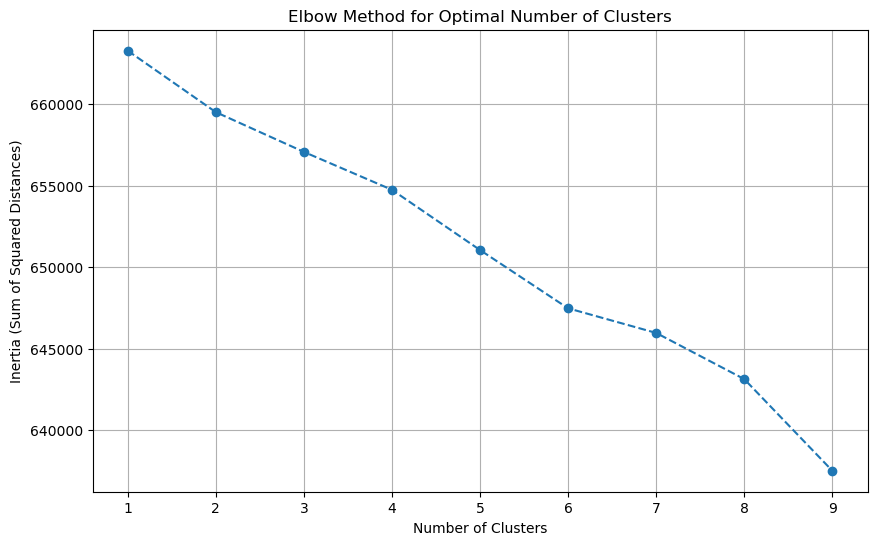

In [13]:
# Plot the Elbow method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

###### From the Elbow Method, it can be seen that from "Cluster 8" onwards, there is a sharp dive. So we chose 8 clusters for our n_clusters

# 7. K-means clustering 

### We will use k-means clustering to identify the different groups of drinks. 

###### Even though there is a hardcoded portion that is aligned with Health Promotion Board's(HPB) standard (Nutrigrade A,B,C,D), we want to make this model future proof. Standards set by HPB will change over time which is one of the factors why we want to make this model fluid to suit changing times. 

In [14]:
# Performing K-means clustering
kmeans = KMeans(n_clusters=8, random_state=2)
kmeans_clusters = kmeans.fit_predict(X_resampled_scaled)

In [15]:
# Using PCA to reduce data dimensionality to 2D for visualization
X_pca_kmeans = pca.transform(X_resampled_scaled)

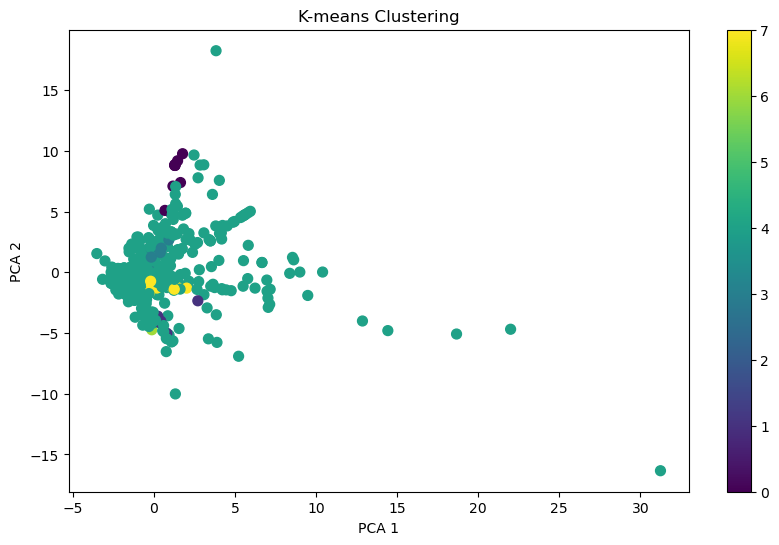

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_kmeans[:, 0], X_pca_kmeans[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.title('K-means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

## End of K-means clustering

### It can seen from the plot that there is no visible clusters. This is because of the following reasons:
    
#### 1. Drinks likely have more or less the same attributes with miniscule changes in terms of ingredients used.
#### 2. Due to time constraints, we were unable to scrape the entire drinks list.

#### 3. However, this is not the end of the world, as according to HPB's standard guideline, even the most miniscule of changes do impact the grade of each drink. This is shown in our Nutrigrade column which includes Sodium that has taken into account of the recommended levels for adults.

# 8. Gaussian Mixture Model Clustering & Spectral Clustering

##### 1. In the following cells, apart of K-Means Clustering, we will also explore other clustering methods as well predicting 8 clusters from the aforementioned elbow method.
    
##### 2. This is to make sure we do not miss out on any potential insights.
##### 3. Hierarchy Agglomerative Clustering Methods and DBScan were tried out as well but yielded unintepretable results.

In [17]:
# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=8, random_state=2)
gmm_clusters = gmm.fit_predict(X_resampled_scaled)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=8, affinity='nearest_neighbors', random_state=2)
spectral_clusters = spectral.fit_predict(X_resampled_scaled)



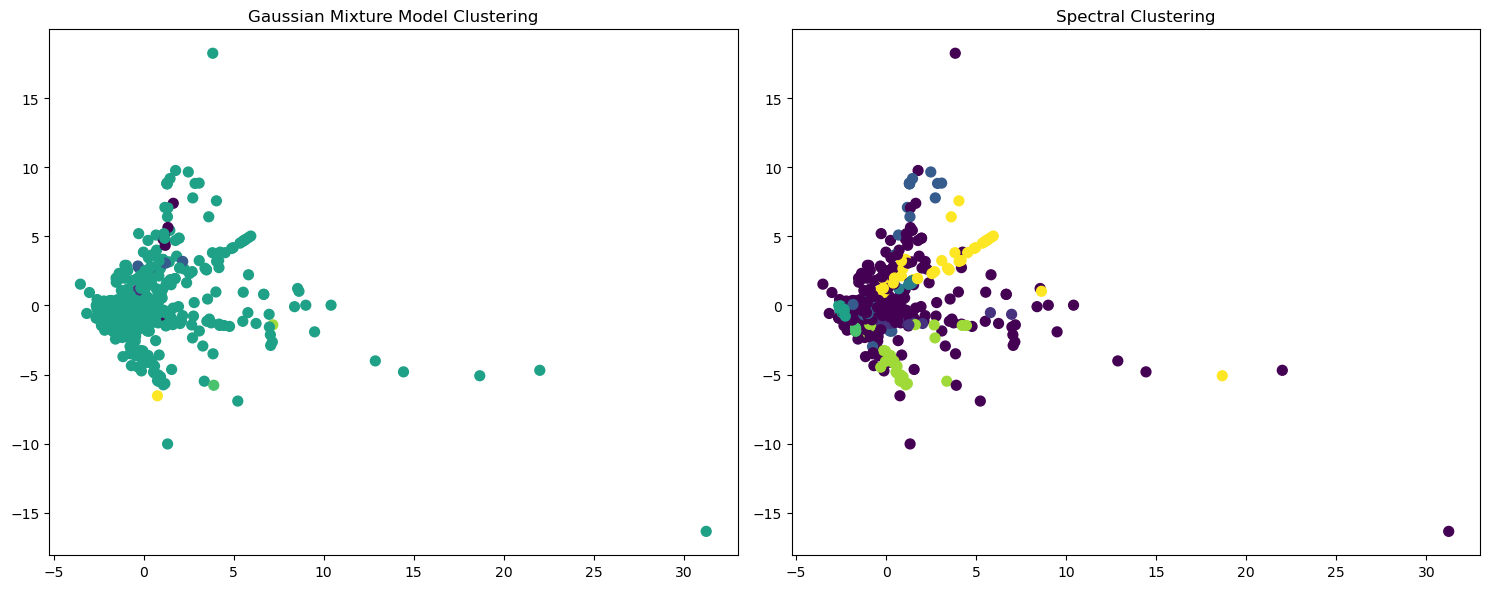

In [18]:
# Create scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# GMM Clustering plot
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_clusters, cmap='viridis', s=50)
ax1.set_title('Gaussian Mixture Model Clustering')

# Spectral Clustering plot
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=spectral_clusters, cmap='viridis', s=50)
ax2.set_title('Spectral Clustering')

plt.tight_layout()
plt.show()

As seen from the 2 plots, it is somewhat similar to k-means clustering.

    1. Again, due to time constraints, we did not explore other visualizations methods.

# Modelling

##### From here, we will proceed with modelling. Our choice of models are of classifiers. eg.(Random Forest, XGBoost)
##### We chose these 2 models because:

###### 1. Feature Importance: Both algorithms provide insights into feature importance, helping in understanding which factors most influence 'nutrigrade' classifications.
    
###### 2. Handling Imbalanced Data: XGBoost, in particular, has parameters to handle class imbalance, which can be crucial if certain 'nutrigrade' classes are underrepresented.
    
###### 3. Flexibility: Both algorithms handle a mix of numerical and categorical features and can be fine-tuned with hyperparameters to optimize performance.
  

# 9(A). Random Forest

In [19]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.3, random_state=2)

In [20]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=2)

In [21]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

In [22]:
# Predict on the test data
y_pred_rf = rf_classifier.predict(X_test)

In [23]:
# Predict on the training data for training accuracy
y_pred_train_rf = rf_classifier.predict(X_train)

In [24]:
# Calculate training and test accuracies
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Training Accuracy: {accuracy_train_rf}")
print(f"Random Forest Test Accuracy: {accuracy_test_rf}")

Random Forest Training Accuracy: 1.0
Random Forest Test Accuracy: 0.9617224880382775


In [25]:
# Classification report for Random Forest
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report:")
print(classification_rep_rf)

Random Forest Classification Report:
              precision    recall  f1-score   support

           A       0.94      1.00      0.97        49
           B       0.98      0.94      0.96        50
           C       0.94      0.96      0.95        52
           D       0.98      0.95      0.96        58

    accuracy                           0.96       209
   macro avg       0.96      0.96      0.96       209
weighted avg       0.96      0.96      0.96       209



### Train scores and Test scores from RF yielded 1.0 and 0.96 respectively.
    
###### 1. We will now look for the best hyper parameters to tune the model
###### 2. This is done so that we don't have to do trial and error on different n_estimators or other metrics

# 9(B). Random Forest tuning using GridSearchCV

###### The param_grid specifies a range of values for each hyperparameter in the Random Forest classifier, and when used in grid search, the algorithm will exhaustively test all combinations of these hyperparameters to find the best model.

In [26]:
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

###### The grid_search initializes a Grid Search with the specified Random Forest classifier and hyperparameter grid, testing each combination using 3-fold cross-validation

In [27]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

###### This code below fits the initialized Grid Search to the training data to find the best model hyperparameters. After fitting, it retrieves and prints the best hyperparameters based on the model performance during cross-validation.
    
###### It may take awhile. Approximately 5mins to run this cell

In [28]:
# Fit the GridSearchCV target to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

Fitting 3 folds for each of 900 candidates, totalling 2700 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


##### The following cells will test the RF model using the best parameters from grid search CV

In [29]:
# Paremeters gotten from best_params
best_params = {
    'bootstrap': False,
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 150
}

rf_classifier_tuned = RandomForestClassifier(**best_params, random_state=2)

In [30]:
# Trains the Random Forest model with the best hyperparameters 
rf_classifier_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=150,
                       random_state=2)

In [31]:
# Predicts nutrigrade for the training data using the tuned Random Forest model.
y_pred_train_tuned = rf_classifier_tuned.predict(X_train)

# Predicts nutrigrade for the test data using the tuned Random Forest model.
y_pred_test_tuned = rf_classifier_tuned.predict(X_test)

In [32]:
# Calculate accuracies
accuracy_train_tuned = accuracy_score(y_train, y_pred_train_tuned)
accuracy_test_tuned = accuracy_score(y_test, y_pred_test_tuned)

In [33]:
print(f"Tuned Random Forest Training Accuracy: {accuracy_train_tuned}")
print(f"Tuned Random Forest Test Accuracy: {accuracy_test_tuned}")

Tuned Random Forest Training Accuracy: 1.0
Tuned Random Forest Test Accuracy: 0.9473684210526315


In [34]:
# Print classification report for the tuned model
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_test_tuned))

Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           A       0.94      0.98      0.96        49
           B       0.96      0.92      0.94        50
           C       0.92      0.94      0.93        52
           D       0.96      0.95      0.96        58

    accuracy                           0.95       209
   macro avg       0.95      0.95      0.95       209
weighted avg       0.95      0.95      0.95       209



## Tuned model lowered test score accuracy

##### It is shown in the tuned model above that after tuning, a better score was not achieved. 

##### Tuning sometimes leads to a slightly worse performance due to over-optimization on the training data, reducing the model's generalization capability on unseen data.

# 10(A). XGBoost

In [35]:
# Encoding the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [36]:
# XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=2, use_label_encoder=False)

In [37]:
# Train the XGBoost classifier with encoded target variable
xgb_classifier.fit(X_train, y_train_encoded, eval_metric='mlogloss')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
# Predict on the test data
y_pred_xgb = xgb_classifier.predict(X_test)
y_pred_train_xgb = xgb_classifier.predict(X_train)

In [39]:
# Calculate training and test accuracies
accuracy_train_xgb = accuracy_score(y_train_encoded, y_pred_train_xgb)
accuracy_test_xgb = accuracy_score(y_test_encoded, y_pred_xgb)

In [40]:
# Check accuracy scores for train and test
accuracy_train_xgb, accuracy_test_xgb

(1.0, 0.9904306220095693)

# 10(B). XGBoost tuning using GridSearchCV

###### Even though we had a test score of .99, we'll still tune the parameters using the machine to find us the best parameters for this model. This is done so because we want to see whether if better results can be acheived.

In [41]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3],
    'objective': ['multi:softprob']
}

grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

In [42]:
grid_search_xgb.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 5120 candidates, totalling 15360 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1],
                         'gamma': [0, 0.1, 0.2, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [50, 100, 150, 200],
                         'objective': ['multi:softprob'],
                         'subsample': [0.7, 0.8, 0.9, 1]},
             scoring='accuracy', verbose=2)

In [43]:
best_params_xgb = grid_search_xgb.best_params_

In [44]:
print(f"Best Hyperparameters for XGBoost: {best_params_xgb}")

Best Hyperparameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.8}


### The cell above will take approximately 30mins to run as it is running approximately 15k iterations

#### Best Hyperparameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'multi:softprob', 'subsample': 0.8}

## In the cell below, we will extract the best parameters we got from the previous cells and inject it into the tuned XGBoost model

In [45]:
# Extracting best parameters from grid search
best_params_xgb = grid_search_xgb.best_params_

# XGBoost classifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params_xgb, random_state=2, use_label_encoder=False)

# Train the classifier with the best parameters on the training data
best_xgb_classifier.fit(X_train, y_train_encoded, eval_metric='mlogloss')


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:
# Predict on the training and test data using the best model
y_pred_train_best_xgb = best_xgb_classifier.predict(X_train)
y_pred_test_best_xgb = best_xgb_classifier.predict(X_test)

In [47]:
# Calculate training and test accuracies
accuracy_train_best_xgb = accuracy_score(y_train_encoded, y_pred_train_best_xgb)
accuracy_test_best_xgb = accuracy_score(y_test_encoded, y_pred_test_best_xgb)

In [48]:
print(f"Best XGBoost Training Accuracy: {accuracy_train_best_xgb}")
print(f"Best XGBoost Test Accuracy: {accuracy_test_best_xgb}")

Best XGBoost Training Accuracy: 1.0
Best XGBoost Test Accuracy: 0.9904306220095693


In [49]:
# Print classification report for the test data
print("Best XGBoost Classification Report:")
print(classification_report(y_test_encoded, y_pred_test_best_xgb))

Best XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       0.96      1.00      0.98        50
           2       1.00      0.96      0.98        52
           3       1.00      1.00      1.00        58

    accuracy                           0.99       209
   macro avg       0.99      0.99      0.99       209
weighted avg       0.99      0.99      0.99       209



## Extracting best parameters

###### We will manually tune the hyper parameters given by GridSearchCV. This is done so that the deployment model will run smoothly without having to rerun the 15,000 iterations

In [50]:
#XGBoost best parameters
best_params_xgb = {
    'colsample_bytree': 0.7,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'objective': 'multi:softprob',
    'subsample': 0.8
}

In [51]:
# Initializing the XGBoost classifier with the optimal parameters and additional configurations.
best_xgb_classifier = xgb.XGBClassifier(**best_params_xgb, random_state=2, use_label_encoder=False)

In [52]:
# Training the XGBoost classifier on the training data using multi-class log loss as the evaluation metric.
best_xgb_classifier.fit(X_train, y_train_encoded, eval_metric='mlogloss')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [53]:
# Predicting target values for training data using the best XGBoost parameters.
y_pred_train_best_xgb = best_xgb_classifier.predict(X_train)

# Predicting target values for test data using the best XGBoost parameters.
y_pred_test_best_xgb = best_xgb_classifier.predict(X_test)

In [54]:
# Calculate training and test accuracies
accuracy_train_best_xgb = accuracy_score(y_train_encoded, y_pred_train_best_xgb)
accuracy_test_best_xgb = accuracy_score(y_test_encoded, y_pred_test_best_xgb)

In [55]:
print(f"Best XGBoost Training Accuracy: {accuracy_train_best_xgb}")
print(f"Best XGBoost Test Accuracy: {accuracy_test_best_xgb}")

Best XGBoost Training Accuracy: 1.0
Best XGBoost Test Accuracy: 0.9904306220095693


# 11. Pickle file for XGBoost to deployment

In [56]:
import pickle

with open('../data/best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_classifier, file)

## Model Summary

###### 1. XGBoost had a very minisucle increase in test score after tuning.
###### 2. The choice of model for deployment will be dependent on discrepancy scores between the train's and test's accuracy score.
###### 3. Upon looking at both results, it is safe to say that we'll be using tuned XGBoost for deployment.

# 12. Conclusion

### Through this comprehensive analysis, we set out to develop a model that provides a more holistic evaluation of the healthiness of drinks, moving beyond just trans fat and sugar levels.

### Our approach was meticulous, encompassing:

### 1. Data Preprocessing: We successfully handled non-numeric columns using One-Hot Encoding and tackled the imbalanced dataset using the Synthetic Minority Oversampling Technique (SMOTE). We also standardized our data, ensuring uniformity across features.

### 2. Dimensionality Reduction: PCA was employed to retain the most critical data variances and also facilitated a 2D visualization of our data.

### 3. Clustering: Multiple techniques like K-means, Gaussian Mixture Model, and Spectral Clustering were explored. Although visible clusters weren't distinctly observed, this exploration added value by emphasizing the nuanced differences in drink attributes.

### 4.Modeling: Both Random Forest and XGBoost classifiers were used. We leveraged GridSearchCV to fine-tune our models, ensuring optimal hyperparameters were selected. Although Random Forest gave promising results, XGBoost slightly edged out in performance after tuning.

### 5. Deployment Preparations: The tuned XGBoost model was serialized into a pickle file, readying it for deployment.

### In conclusion, while our initial nutrigrade labels were limited in scope, our refined model, using XGBoost, promises a more comprehensive and nuanced evaluation of drinks' healthiness. This model is not only aligned with current standards set by the Health Promotion Board but is also built with the foresight of evolving standards. Our work here underscores the importance of continuous refinement and leveraging advanced machine learning techniques to make more informed health decisions.